<a href="https://colab.research.google.com/github/abishekP101/Pytorch/blob/main/Animal_faces_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abishek11prasad
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:11<00:00, 66.0MB/s]


In [ ]:
{"username":"abishek11prasad","key":"0f0de555bf2b3a07d095cb1aac36a121"}

{'username': 'abishek11prasad', 'key': '0f0de555bf2b3a07d095cb1aac36a121'}

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset , DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
image_path = []
labels = []

for i in os.listdir('/content/animal-faces/afhq/'):
    for j in os.listdir('/content/animal-faces/afhq/'+i):
        for image in os.listdir(f"/content/animal-faces/afhq/{i}/{j}"):
          image_path.append('/content/animal-faces/afhq/'+i+'/'+j+'/'+ image)
          labels.append(j)

data_df = pd.DataFrame({'image_path':image_path,'labels':labels})
data_df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [5]:
data_df['image_path'][0]

'/content/animal-faces/afhq/train/dog/pixabay_dog_003969.jpg'

In [6]:
data_df['labels'].unique()

array(['dog', 'wild', 'cat'], dtype=object)

In [7]:
train = data_df.sample(frac=0.7)


In [8]:
train.index

Index([15101, 15933, 15511,  6642, 13868,  8107, 13226, 12734,  7118,  9081,
       ...
       10759,  5208,  9726,  9917,  4661,  9756, 16128,  6560, 12262,  6604],
      dtype='int64', length=11291)

In [9]:
test = data_df.drop(train.index)

In [10]:
val = test.sample(frac=0.5)

In [11]:
test = data_df.drop(val.index)

In [12]:
label_encoder = LabelEncoder()

label_encoder.fit(data_df['labels'])

transforms = transforms.Compose([
    transforms.Resize((128 , 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [13]:
class CustomImageDataset(Dataset):
  def __init__(self , df , transform = None):
    self.df = df
    self.transforms = transforms
    self.labels = torch.tensor(label_encoder.transform(df['labels'])).to(device)

  def __len__(self):
    return len(self.df)

  def __getitem__(self , idx):
    image_path = self.df.iloc[idx]['image_path']
    label = self.labels[idx]

    image = Image.open(image_path).convert('RGB')
    if self.transforms:
      image = self.transforms(image).to(device)

    return image , label

In [14]:
train_dataset = CustomImageDataset(df = train , transform = transforms)
test_dataset = CustomImageDataset(df = test , transform = transforms)
val_dataset = CustomImageDataset(df = val , transform = transforms)

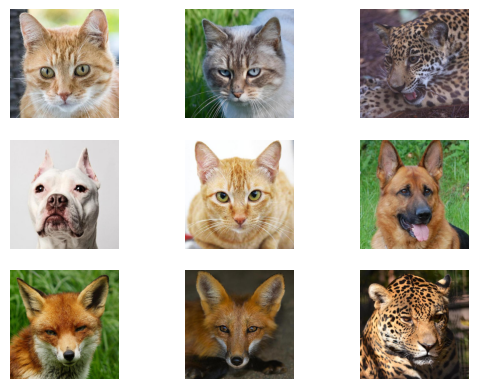

In [15]:
n_rows = 3
n_cols = 3

f , axarr = plt.subplots(n_rows , n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row , col].imshow(image)
    axarr[row , col].axis('off')

plt.show()

In [16]:
learning_rate = 1e-4
batch_size = 16
epochs = 10

In [17]:
train_loader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True)
test_loader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size = batch_size , shuffle = True)

In [30]:
class Net(nn.Module):
  def __init__(self):
    super(Net , self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3 , out_channels=32 , kernel_size=3 , padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=3 , padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64 , out_channels=128 , kernel_size=3 , padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5) # Added dropout layer

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16) , 64) # Reduced the number of output features

    self.output = nn.Linear(64 , len(data_df['labels'].unique()))


  def forward(self , x):
      x  = self.conv1(x)
      x = self.bn1(x)
      x = self.pooling(x)
      x = self.relu(x)


      x  = self.conv2(x)
      x = self.bn2(x)
      x = self.pooling(x)
      x = self.relu(x)


      x  = self.conv3(x)
      x = self.bn3(x)
      x = self.pooling(x)
      x = self.relu(x)


      x = self.flatten(x)
      x = self.linear(x)
      x = self.relu(x)
      x = self.dropout(x) # Added dropout


      x = self.output(x)
      return x

In [31]:
model = Net().to(device)

In [32]:
from torchsummary import summary
summary(model , (3 , 128 , 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         MaxPool2d-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        MaxPool2d-11          [-1, 128, 16, 16]               0
             ReLU-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                   

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters() , lr = learning_rate)

In [34]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0
  for inputs , labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs , labels)
    total_loss_train += train_loss.item()
    train_loss.backward()
    train_acc = (torch.argmax(outputs , axis=1)==labels).sum().item()

    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs , labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs , labels)
      total_loss_val += val_loss.item()
      val_acc = (torch.argmax(outputs , axis=1)==labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000 , 4))
  total_loss_val_plot.append(round(total_loss_val/1000 , 4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) *100 , 4))
  total_acc_val_plot.append(round((total_acc_val/val_dataset.__len__()) *100 , 4))

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {round(total_loss_train/1000 , 4)} | Val Loss: {round(total_loss_val/1000 , 4)} | Train Acc: {round((total_acc_train/train_dataset.__len__())*100 , 4)} | Val Acc: {round((total_acc_val/val_dataset.__len__())*100 , 4)}')


Epoch 1/10 | Train Loss: 0.2808 | Val Loss: 0.0368 | Train Acc: 84.4832 | Val Acc: 91.281
Epoch 2/10 | Train Loss: 0.1384 | Val Loss: 0.0354 | Train Acc: 92.9236 | Val Acc: 91.8595
Epoch 3/10 | Train Loss: 0.1014 | Val Loss: 0.0227 | Train Acc: 94.7923 | Val Acc: 94.3802
Epoch 4/10 | Train Loss: 0.0853 | Val Loss: 0.0227 | Train Acc: 95.4831 | Val Acc: 94.876
Epoch 5/10 | Train Loss: 0.0695 | Val Loss: 0.023 | Train Acc: 96.2537 | Val Acc: 95.4545
Epoch 6/10 | Train Loss: 0.0652 | Val Loss: 0.0194 | Train Acc: 96.6079 | Val Acc: 96.0331
Epoch 7/10 | Train Loss: 0.0579 | Val Loss: 0.0193 | Train Acc: 96.9888 | Val Acc: 96.0744
Epoch 8/10 | Train Loss: 0.0558 | Val Loss: 0.0172 | Train Acc: 96.8293 | Val Acc: 96.1983
Epoch 9/10 | Train Loss: 0.046 | Val Loss: 0.019 | Train Acc: 97.4847 | Val Acc: 96.6116
Epoch 10/10 | Train Loss: 0.0456 | Val Loss: 0.0207 | Train Acc: 97.5024 | Val Acc: 95.5785


In [36]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs , labels in test_loader:
    pred = model(inputs)
    acc = (torch.argmax(pred , axis=1)==labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(pred , labels)
    total_loss_test += test_loss.item()

  print(f'Test Loss: {round(total_loss_test/1000 , 4)} | Test Acc: {round((total_acc_test/test_dataset.__len__())*100 , 4)}')


Test Loss: 0.0664 | Test Acc: 97.221


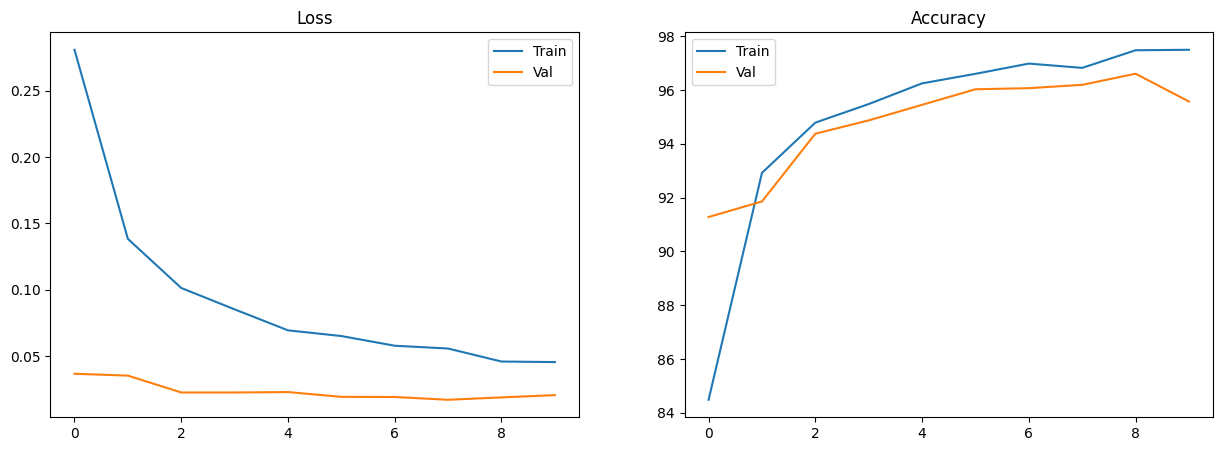

In [37]:
fig , axs = plt.subplots(nrows=1 , ncols=2 , figsize=(15,5))
axs[0].plot(total_loss_train_plot , label='Train')
axs[0].plot(total_loss_val_plot , label='Val')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot , label='Train')
axs[1].plot(total_acc_val_plot , label='Val')
axs[1].set_title('Accuracy')
axs[1].legend()

In [39]:
def inference(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transforms(image).to(device)
    image = image.unsqueeze(0)

    output = model(image)
    output = torch.argmax(output)
    output = label_encoder.inverse_transform([output.detach().cpu().item()])
    return output

In [41]:
inference('/content/Screenshot 2025-09-06 075325.png')

array(['wild'], dtype=object)